In [1]:
import torch
from torchvision import transforms
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

from PIL import Image
import numpy as np
import os

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Flatten,BatchNormalization,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ReduceLROnPlateau

import cv2


# Inspekting images

In [2]:
# Create a list of all the image filenames
IMG_PATH = "brain_tumor_dataset"
all_images = []
for folder in ['yes', 'no']:
    folder_path = os.path.join(IMG_PATH, folder)
    for filename in os.listdir(folder_path):
        
         all_images.append(os.path.join(folder_path, filename))

# Create a list of corresponding labels (0 for 'no', 1 for 'yes')
labels = [1 if 'Y' in filename else 0 for filename in all_images]

# Split the dataset into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(all_images, labels, test_size=0.05, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)


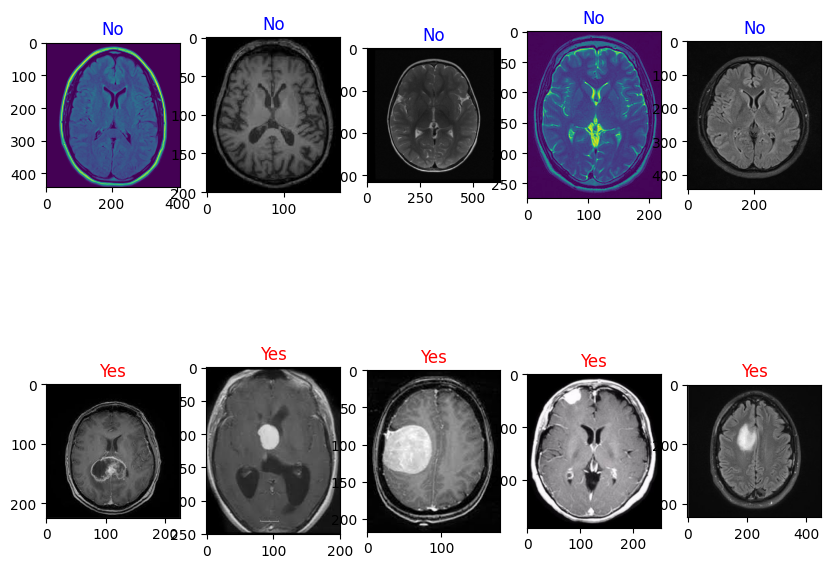

In [3]:
# Define the labels and their corresponding colors
labels = {0: 'No', 1: 'Yes'}
colors = {0: 'blue', 1: 'red'}

# Plot some images from the train set for each label
fig, axs = plt.subplots(2, 5, figsize=(10, 8))
for i, label in enumerate([0, 1]):
    images = [x for x, y in zip(X_train, y_train) if y == label][:5]
    for j, image_path in enumerate(images):
        img = plt.imread(image_path)
        axs[i, j].imshow(img)
        axs[i, j].set_title(labels[label], color=colors[label])
plt.show()

Most images in the dataset is in grayscale, while some are colored. To normalize all images we need to apply grayscaling and resizing them to the same size and shape.

# Naive Approach

## Preprocessing and convert to tensor

In [28]:
def convertToTensor(path_list, image_size):
    convert_tensor = transforms.ToTensor( )
    gray_scale = transforms.Grayscale()
    first = True

    for path in path_list:
        image = Image.open(path)
        image = image.resize((image_size, image_size))
        image = gray_scale(image)
        
        tensor = convert_tensor(image).numpy()
        tensor = tf.convert_to_tensor(tensor)
        tensor = tf.transpose(tensor, perm=[2, 1, 0])
        if first:
            image_tensor = np.array([tensor])
            first = False
        else:
            image_tensor = np.concatenate((image_tensor, np.array([tensor])))
    return image_tensor

In [3]:
convert_tensor = transforms.ToTensor( )
gray_scale = transforms.Grayscale()
directory = 'no'
first = True

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        image = Image.open(f)
        image = image.resize((224,224))
        image = gray_scale(image)
        
        tensor = convert_tensor(image).numpy()
        tensor = tf.convert_to_tensor(tensor)
        tensor = tf.transpose(tensor, perm=[2, 1, 0])
        if first:
            no_images = np.array([tensor])
            no_labels = np.array([[0]])
            first = False
        else:
            no_images = np.concatenate((no_images, np.array([tensor])))
            no_labels = np.concatenate((no_labels, np.array([[0]])))


In [4]:
convert_tensor = transforms.ToTensor()
gray_scale = transforms.Grayscale()
directory = 'yes'
first = True

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        image = Image.open(f)
        image = image.resize((224,224))
        image = gray_scale(image)
        
        tensor = convert_tensor(image).numpy()
        tensor = tf.convert_to_tensor(tensor)
        tensor = tf.transpose(tensor, perm=[2, 1, 0])
        if first:
            yes_images = np.array([tensor])
            yes_labels = np.array([[1]])
            first = False
        else:
            yes_images = np.concatenate((yes_images, np.array([tensor])))
            yes_labels = np.concatenate((yes_labels, np.array([[1]])))

In [5]:
images = np.concatenate((no_images, yes_images))
labels = np.concatenate((no_labels, yes_labels))

In [6]:
train_val_images, test_images, train_val_labels, test_labels = train_test_split(images, labels, test_size = 0.05, random_state = 42)
train_images, val_images, train_labels, val_labels = train_test_split(train_val_images, train_val_labels, test_size = 0.05, random_state = 42)
train_images, test_images, val_images = train_images.astype("float32") / 255.0, test_images.astype("float32") / 255.0, val_images.astype("float32") / 255.0

In [7]:
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(2))
model.summary()

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(val_images, val_labels))

In [ ]:
# Plot the training and validation accuracy curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation loss curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(test_images)
y_pred = np.round(y_pred).astype(int)

# VVG19

## Preprocessing

Apply simple preprocessing that resizes each image to the same size cubic shape.

In [ ]:
def proprocessing(path_list, image_size):
    images = []
    for path in path_list:
        image = cv2.imread(path)
        image = cv2.resize(image,
                           dsize = (image_size, image_size),
                           interpolation = cv2.INTER_CUBIC,
                           )
        images.append(image)
    return np.array(images)

Apply the preprocessing to each of the data splits

In [5]:
image_size = 224

X_train_pre = proprocessing(X_train, image_size)
X_test_pre = proprocessing(X_test, image_size)
X_val_pre = proprocessing(X_val, image_size= image_size)

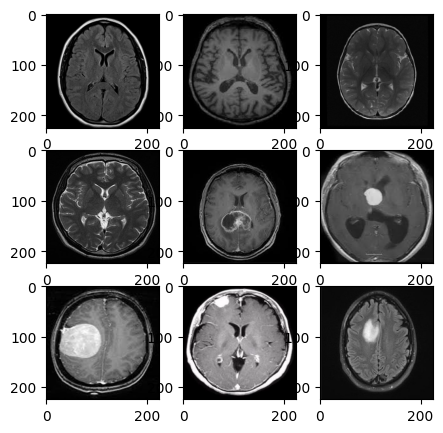

In [13]:
plt.figure(figsize=(5, 5))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_train_pre[i], cmap = "gray")
plt.show()

Use VGG19 special preprocessing to the image

In [6]:
X_train_pre_vgg = np.array([preprocess_input(image) for image in X_train_pre])
X_val_pre_vgg = np.array([preprocess_input(image) for image in X_val_pre])
X_test_pre_vgg = np.array([preprocess_input(image) for image in X_test_pre])

We see that the preprocessing is highly effective in identifying removing noice, leaving cleare shapes of brain tumors.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


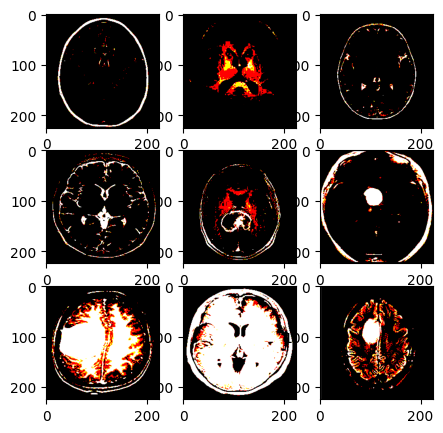

In [7]:
plt.figure(figsize=(5, 5))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_train_pre_vgg[i], cmap = "gray")
plt.show()

## Modeling

Defining the pretrained model and adding a few layers on top

In [8]:
base_model = VGG19(
weights='imagenet',
include_top=False,
input_shape=(image_size, image_size, 3)
)

# Create a new model by adding a few layers on top of the pre-trained model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Freeze the weights of the pre-trained model
model.layers[0].trainable = False

# Compile the model with appropriate loss function, optimizer and metrics
model.compile(
loss='binary_crossentropy',
optimizer=Adam(),
metrics=['accuracy']
)

# Print the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________


In [9]:
train_datagen = ImageDataGenerator(
rescale=1./255,
rotation_range=20,
width_shift_range=0.1,
height_shift_range=0.1,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest'
)

# Create the training data generator using the training dataset and the data generator
train_generator = train_datagen.flow(
X_train_pre_vgg,
y_train,
batch_size=32
)

# Define the validation data generator with appropriate data preprocessing
val_datagen = ImageDataGenerator(rescale=1./255)

# Create the validation data generator using the validation dataset and the data generator
val_generator = val_datagen.flow(X_val_pre_vgg, y_val, batch_size=18)


In [10]:
history = model.fit(
train_generator,
epochs=10,
validation_data=val_generator
)

Epoch 1/10
6/6 [==============================] - ETA: 0s - loss: 0.7185 - accuracy: 0.6000 

## Naive method

2/2 - 0s - loss: 6.0145 - accuracy: 0.6078 - 65ms/epoch - 33ms/step


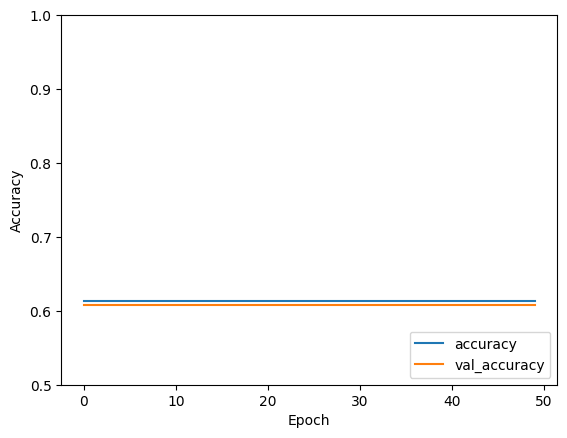

In [131]:
# Plot the training and validation accuracy curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot the training and validation loss curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## VVG 19 with preprocessing of images